# 4. MLP応用
## 概要
この試験ではChapter04で学習した、深層学習の基礎である多層パーセプトロン(応用)を穴埋め形式で実装します。<br>
予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
試験問題文は<font color="Red">赤字</font>で表示されています。<br>
また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：5~8時間
> テーマ
>> **正則化**: MNIST<br>
>> **データ拡張**: rabbit.jpg<br>
>> [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)を利用します.<br>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # ライブラリのインストール
    %pip install --no-warn-conflicts torch==2.1.1 torchvision==0.16.1
else:
    print("Not Google Colab")


Not Google Colab


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [2]:
# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # マウントを行う
    from google.colab import drive

    drive.mount("/content/drive")
else:
    print("Not Google Colab")


Not Google Colab


### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"


### データの読み込み


In [4]:
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
mnist_train = datasets.MNIST(
    root="./data", download=True, train=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", download=True, train=False, transform=transform
)

# 少データでの学習を試すため、訓練用のデータを750個だけ取り出す
n_train_data = 750
indices = torch.randperm(len(mnist_train))[:n_train_data].numpy()
train_sampler = SubsetRandomSampler(indices)
train_dataloader = DataLoader(mnist_train, batch_size=100, sampler=train_sampler)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)

## 正則化（PyTorch）

### ドロップアウト
ドロップアウトとは、学習時に指定された割合のノードをランダムに消すテクニックであり、部分的なネットワークのアンサンブル学習として捉えることができます。これによって、表現力が高いMLPにおいても過学習を抑制することが可能になる場合あります。

ここでは、ドロップアウトのクラスをNumPyライブラリを用いて実装します。


<font color="Red">問1. 生成したrandommatrixがself.dropout_ratioより大きければTrue、そうでなければFalseを返すマスクを生成します。</font><br>



In [5]:
class Dropout:
    """
    このクラスは、ニューラルネットワークの訓練時にドロップアウトを適用するためのクラスです。

    Attributes:
        dropout_ratio (float): ドロップアウト率。どの程度の割合でノードを無効化するかを表します。デフォルトは0.5。
        mask (ndarray): ドロップアウト時に使用するマスク。Noneで初期化され、訓練時に生成されます。

    Note:
        - `__call__` メソッドは、訓練時には入力 `x` の各要素をランダムにドロップアウトし、評価時にはドロップアウトを行わずに入力の一部をスケーリングします。
        - ドロップアウトマスク `self.mask` は、各要素がドロップアウトするかどうかを示す真偽値の配列です。
        - `backward` メソッドは、順伝播時に使用された同じマスクを使って勾配を伝播させます。
    """

    def __init__(self, dropout_ratio=0.5):
        """
        初期化メソッド

        Args:
            dropout_ratio (float, optional): ドロップアウト率。デフォルトは0.5。
        """
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x, train_flg=True):
        """
        ドロップアウトの実行

        Args:
            x (ndarray): 入力データ。
            train_flg (bool, optional): 訓練モードの場合はTrue。デフォルトはTrue。

        Returns:
            ndarray: ドロップアウト適用後のデータ。

        Note:
            訓練モードではランダムにニューロンを無効化します。
            推論モードでは、ドロップアウト率に応じて入力をスケーリングします。
        """
        if train_flg:
            randommatrix = np.random.rand(*x.shape)
            self.mask = randommatrix > self.dropout_ratio ### 問1 ###
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        """
        逆伝播処理

        Args:
            dout (ndarray): 上流からの勾配。

        Returns:
            ndarray: 逆伝播された勾配。

        Note:
            逆伝播時には、順伝播時に無効化されたニューロンに対応する勾配は0になります。
        """
        return dout * self.mask


また、PyTorchでDropoutを実装する場合は`torch.nn.Dropout()`が用いられます。

* <font color="Red">問2. PyTorchでDropoutを実装しましょう。</font>
  * <font color="Red">問2-1. 確率 `0.5` で出力を0にするDropoutのインスタンスを生成しましょう。</font>
  * <font color="Red">問2-2. 入力`input` に対しDropoutを適用する処理を記述しましょう。</font>


In [6]:
torch.manual_seed(0)
input = torch.randn(3, 4)
print('入力: \n', input)

m = torch.nn.Dropout(p=0.5) ### 問2-1 ###
output = m(input) ### 問2-2 ###
print('Dropout後の出力: \n', output)


入力: 
 tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [-0.7193, -0.4033, -0.5966,  0.1820]])
Dropout後の出力: 
 tensor([[ 3.0820, -0.0000, -4.3576,  0.0000],
        [-2.1690, -2.7972,  0.0000,  1.6761],
        [-0.0000, -0.0000, -0.0000,  0.0000]])


### ドロップコネクト
ドロップアウトがノードを消すテクニックであったのに対し、ドロップコネクトとは学習時に指定された割合のパラメータをランダムに消すテクニックです。<br>
ドロップアウトよりも優れた精度を誇りますが、乱数のシード値が異なると同じ性能を達成するのが困難であるという課題があります

ここでは、ドロップコネクトのクラスをNumPyライブラリを用いて実装します。

<font color="Red">問3. self.drop_rateが０から１の範囲に収まる確率値である場合は、０か１をランダムに配置するマスクを生成します。</font><br>


In [7]:
class DropConnect(nn.Module):
    """
    DropConnectを実装するクラスです。
    DropConnectは、ニューロンではなく重みをランダムに無効化します。

    Attributes:
        drop_rate (float): DropConnectを適用する確率（無効化する重みの割合）。デフォルトは0.5。
        layer (torch.nn.Module): DropConnectを適用する層。

    Note:
        - `forward` メソッドは、訓練時にのみドロップコネクトを適用し、評価時には通常の重みを使用します。
        - ドロップコネクトは、層の重み `W` の要素をランダムに無効化します。無効化は、指定された `drop_rate` に基づいて行われます。
        - 無効化された重みを持つ新しいテンソル `dropped_W` は、入力 `x` に対して線形変換を行うために使用されます。
        - このクラスはPyTorchに依存しており、DropConnectを実現するためにPyTorchのテンソル操作を使用します。
    """

    def __init__(self, layer, drop_rate=0.5):
        """
        初期化メソッド

        Args:
            layer (torch.nn.Module): 正則化を適用する層。
            drop_rate (float, optional): DropConnectを適用する確率。デフォルトは0.5。
        """
        super().__init__()
        self.drop_rate = drop_rate
        self.layer = layer
        self.mask = None

    def forward(self, x):
        """
        順伝播処理

        Args:
            x (Tensor): 入力データ。

        Returns:
            Tensor: 順伝播の結果。

        Examples:
            >>> dropconnect_layer = DropConnect(nn.Linear(10, 5), 0.3)
            >>> input_data = torch.randn(1, 10)
            >>> output_data = dropconnect_layer(input_data)
            >>> print(output_data.size())
            torch.Size([1, 5])

        Note:
            訓練モードでは、層の重みにDropConnectを適用します。
            推論モードでは、通常の順伝播を行います。
        """
        if self.training and 0.0 <= self.drop_rate <= 1.0:  ### 問3 ###
            keep_rate = 1.0 - self.drop_rate
            mask_tensor = torch.rand_like(self.layer.weight).to(self.layer.weight.device) + keep_rate
            torch.floor_(mask_tensor)
            mask_tensor *= self.layer.weight
            x = F.linear(x, mask_tensor, self.layer.bias)
            return x
        else:
            # 簡易実装のため、重み無効化の有無による出力値の変化を打ち消すスケーリング処理は論文と異なる
            return self.layer(x) * (1.0 - self.drop_rate)


## ドロップアウトとドロップコネクトを含めたMLPの実装

### 線形結合層などの定義

chapter02,chapter03試験のコードをpytorchを用いて実装しているものであり、読み飛ばしていただいて構いません。

In [8]:
class FullyConnectedLayer(nn.Module):
    """
    全結合層（Fully Connected Layer）を実装するクラスです。
    ニューラルネットワークにおける基本的な完全連結層（線形層）を実装します。

    Attributes:
        in_features (int): 層の入力値の次元数。
        out_features (int): 層の出力値の次元数。
        weight (Parameter): 層の重みを保持するパラメータ。
        bias (Parameter): 層のバイアスを保持するパラメータ。

    Note:
        - このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。
        - 層はランダムな初期値を持つ重みとバイアスのパラメータを保持します。
    """

    def __init__(self, input_dim, output_dim):
        """
        初期化メソッド

        Args:
            input_dim (int): 層の入力値の次元数。
            output_dim (int): 層の出力値の次元数。
        """
        super(FullyConnectedLayer, self).__init__()
        self.in_features = input_dim  # 入力値の次元
        self.out_features = output_dim  # 出力値の次元

        weight = torch.randn(input_dim, output_dim) * 0.01
        bias = torch.randn(output_dim) * 0.01

        self.weight = nn.parameter.Parameter(weight)
        self.bias = nn.parameter.Parameter(bias)

    def forward(self, x):
        """順伝播処理
        入力データに対して線形変換を適用する。

        Args:
            x (:obj:`torch.Tensor`): 入力データ。

        Returns:
            torch.Tensor: 変換後の出力データ。

        Examples:
            >>> layer = FullyConnectedLayer(10, 5)
            >>> input_data = torch.randn(1, 10)
            >>> output_data = layer(input_data)
            >>> print(output_data.size())
            torch.Size([1, 5])

        Note:
            - 入力データは、層の重みと行列乗算され、バイアスが加えられます。
            - この関数は、一般的な線形変換（y = Wx + b）を実行します。
        """
        x = torch.mm(x, self.weight) + self.bias
        return x


In [9]:
class ReLU(nn.Module):
    """ReLU（Rectified Linear Unit）活性化関数の実装
    入力が0以下の場合は0を出力し、それ以外の場合は入力をそのまま出力します。

    Note:
        - このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。
        - ソフトマックス関数は、入力行列の各列を確率分布に変換します。
    """

    def __init__(self):
        """
        ReLUクラスの初期化
        """
        super(ReLU, self).__init__()

    def forward(self, x):
        """順伝播処理
        入力データにReLU活性化関数を適用する。

        Args:
            x (:obj:`torch.Tensor`): 入力データ。

        Returns:
            torch.Tensor: ReLU活性化関数が適用された出力データ。

        Examples:
            >>> relu = ReLU()
            >>> input = torch.tensor([-1.0, 0.0, 1.0])
            >>> output = relu(input)
            >>> print(output)
            tensor([0., 0., 1.])

        Note:
            入力データに対して、0以下の場合は0を、それ以外の場合は入力値をそのまま出力します。
        """
        mask = x <= 0
        x[mask] = 0
        return x


### モデルの定義

正則化を行わないMLPクラスを実装します<br>
今回構築するモデルのアーキテクチャは以下のようになっています。<br>

In [10]:
class MLP_classifier(nn.Module):
    """
    多層パーセプトロン（MLP）分類器クラス
    基本的な多層パーセプトロンモデルを実装した分類器です。

    Attributes:
        fc1 (torch.nn.Linear): 入力層から第一隠れ層への線形変換層。
        relu1 (torch.nn.ReLU): 第一隠れ層の後のReLU活性化関数。
        fc2 (torch.nn.Linear): 第一隠れ層から第二隠れ層への線形変換層。
        relu2 (torch.nn.ReLU): 第二隠れ層の後のReLU活性化関数。
        fc3 (torch.nn.Linear): 第二隠れ層から出力層への線形変換層。

    Note:
        - このモデルは、手書き数字認識などの簡単な分類タスクに適しています。
        - 入力データは784次元であることを前提としています（例えば、28x28ピクセルの画像をフラット化したもの）。
        - 出力層の次元数は10です（0から9までの数字の分類を想定）。
        - このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。

    """

    def __init__(self):
        """
        ネットワークの層を初期化します。
        構造
        x -> fc(784, 256) -> relu -> fc(256, 256) -> relu -> fc(256, 10) -> x
        """
        super(MLP_classifier, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        """
        順伝播処理

        ネットワークを通して入力データを順伝播させ、出力データを計算します。

        Args:
            x (Tensor): モデルへの入力データ。

        Returns:
            Tensor: モデルの出力データ。

        Examples:
            >>> mlp = MLP_classifier()
            >>> input = torch.randn(1, 784)
            >>> output = mlp(input)
            >>> print(output.size())
            torch.Size([1, 10])

        Note:
            入力データは全結合層とReLU活性化関数を経て、最終的な出力データが生成されます。
        """
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)

        return x


ドロップアウトを含めたMLPクラスを実装します。<br>
今回構築するモデルのアーキテクチャは以下のようになっています。<br>



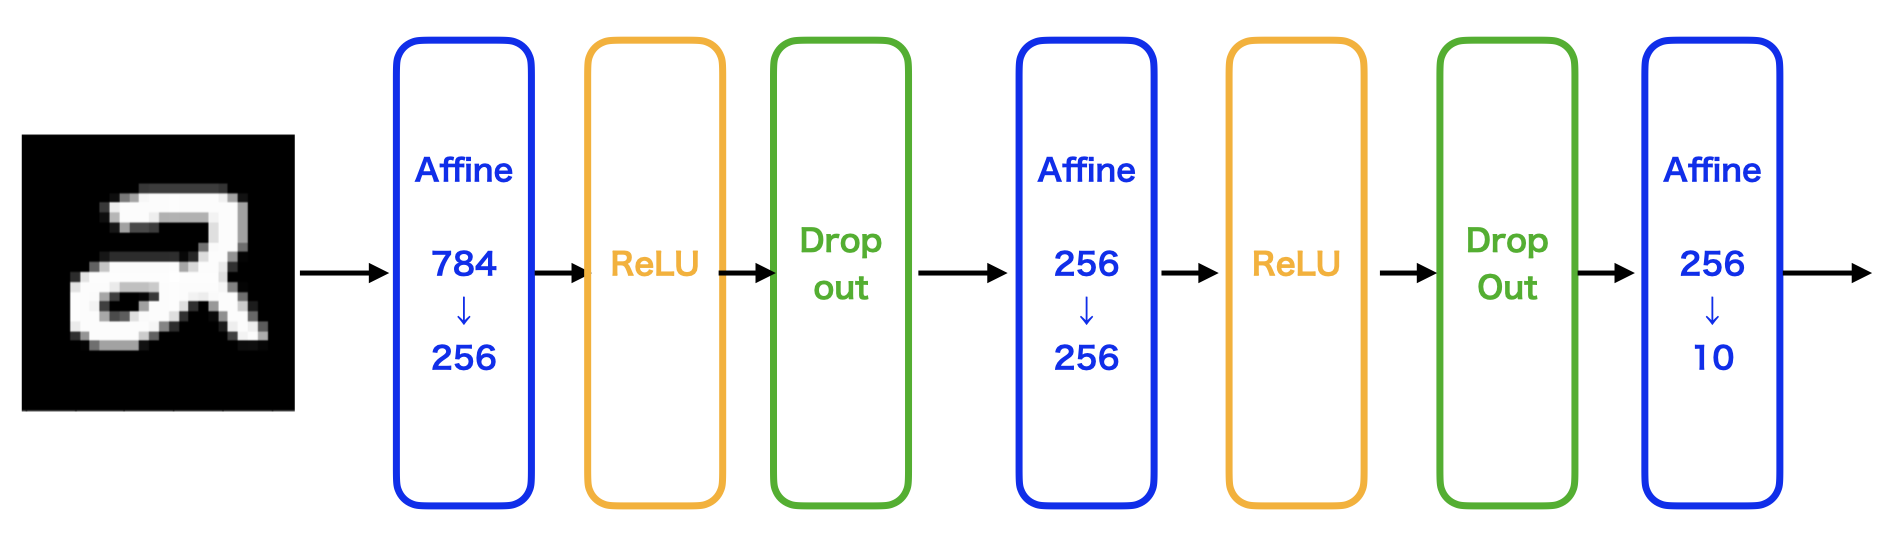



* <font color="Red">問4.ドロップアウトを含めたMLPクラスを完成させてください。</font><br>
    * <font color="Red">問4-1. 【forward関数】第1の全結合層の出力に対してドロップアウトを適用する処理を記述しましょう。</font><br>
    * <font color="Red">問4-2. 【forward関数】第2の全結合層の出力に対してドロップアウトを適用する処理を記述しましょう。</font><br>

In [11]:
class MLPClassifierDropout(nn.Module):
    """ドロップアウトを含む多層パーセプトロン（MLP）分類器クラス

    Attributes:
        fc1 (:obj:`nn.Linear`): 最初の全結合層（入力層から第1隠れ層への層:784次元から256次元）。
        relu1 (:obj:`nn.ReLU`): 第1隠れ層のReLU活性化関数。
        dropout1 (:obj:`nn.Dropout`): 第1隠れ層のドロップアウト。
        fc2 (:obj:`nn.Linear`): 第2の全結合層（第1隠れ層から第2隠れ層への層:256次元から256次元）。
        relu2 (:obj:`nn.ReLU`): 第2隠れ層のReLU活性化関数。
        dropout2 (:obj:`nn.Dropout`): 第2隠れ層のドロップアウト。
        fc3 (:obj:`nn.Linear`): 第3の全結合層（第2隠れ層から出力層への層:256次元から10次元）。

    Note:
        - このモデルは、手書き数字認識などの簡単な分類タスクにDropoutを適用したクラスです。
        - 入力データは784次元であることを前提としています（例えば、28x28ピクセルの画像をフラット化したもの）。
        - 出力層の次元数は10です（0から9までの数字の分類を想定）。
        - このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。
    """

    def __init__(self):
        """
        ネットワークの層を初期化します。
        構造
        x -> fc(784, 256) -> relu -> dropout -> fc(256, 256) -> relu -> dropout -> fc(256, 10) -> x
        """
        super(MLPClassifierDropout, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        """
        順伝播処理
        入力データに対してデータを順伝播させ、ドロップアウトを適用した後、出力データを計算します。

        Args:
            x (:obj:`torch.Tensor`): 入力データ。

        Returns:
            torch.Tensor: モデルによる出力データ。

        Examples:
            >>> mlp_dout = MLPClassifierDropout()
            >>> input = torch.randn(1, 784)
            >>> output = mlp_dout(input)
            >>> print(output.size())
            torch.Size([1, 10])

        Note:
            入力データは全結合層とReLU活性化関数を経て、ドロップアウトが適用され、最終的な出力データが生成されます。
        """
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x) ### 問4-1 ###
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x) ### 問4-2 ###
        x = self.fc3(x)

        return x


ドロップコネクトを含めたMLPクラスを実装します。<br>
今回構築するモデルのアーキテクチャは以下のようになっています。<br>



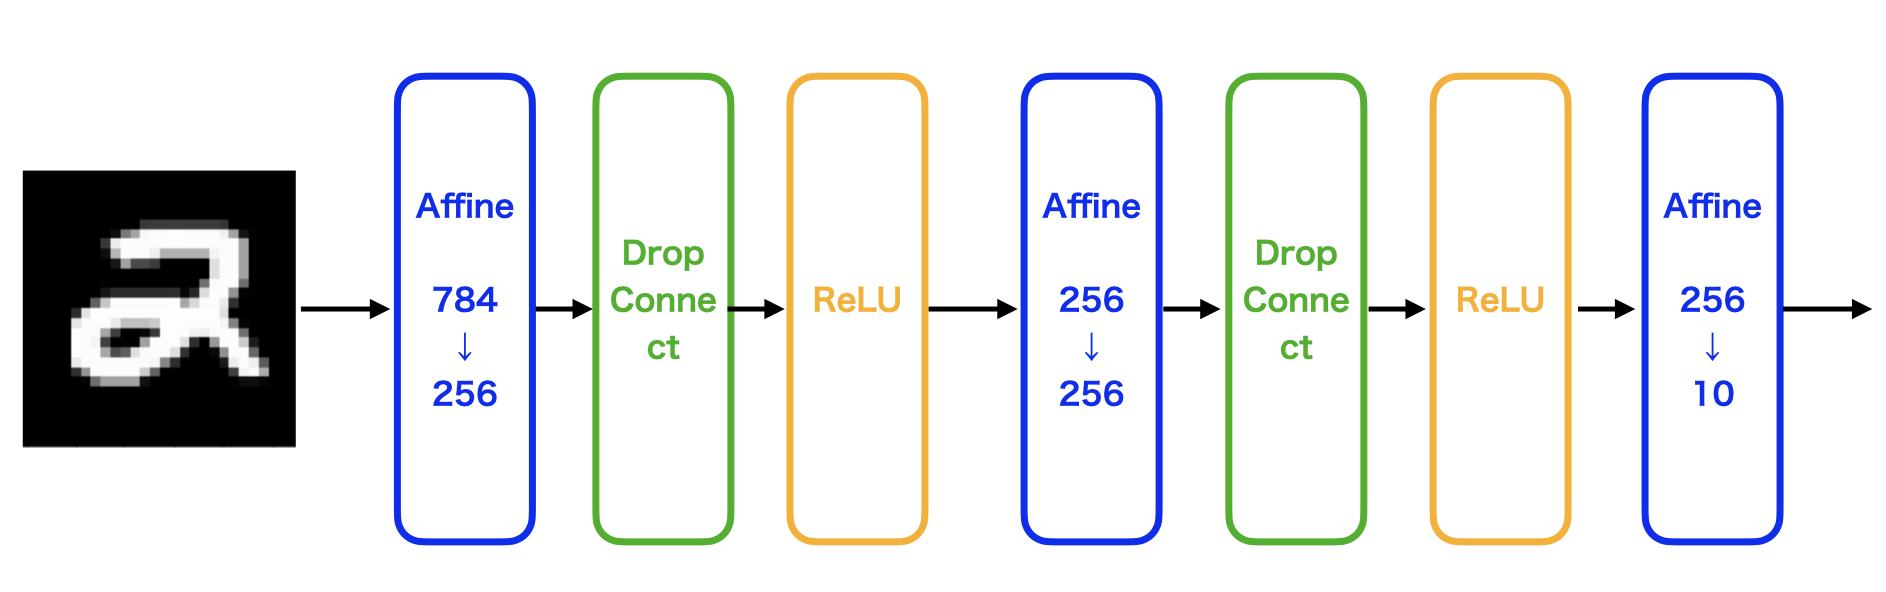



* <font color="Red">問5.ドロップコネクトを含めたMLPクラスを完成させてください。</font><br>
    * <font color="Red">問5-1. 【forward関数】第1の全結合層の出力に対してドロップコネクトを適用する処理を記述しましょう。</font><br>
    * <font color="Red">問5-2. 【forward関数】第2の全結合層の出力に対してドロップコネクトを適用する処理を記述しましょう。</font><br>

In [12]:
class MLPClassifierDropConnect(nn.Module):
    """DropConnectを適用した多層パーセプトロン（MLP）分類器

    Args:
        drop_rate (float, optional): DropConnectにおいて無効化する重みの割合。デフォルトは0.5。

    Attributes:
        fc1 (torch.nn.Linear): 最初の線形層。
        dropconnect1 (DropConnect): 最初の線形層に適用されるDropConnect層。
        relu1 (torch.nn.ReLU): 最初のReLU活性化関数。
        fc2 (torch.nn.Linear): 二番目の線形層。
        dropconnect2 (DropConnect): 二番目の線形層に適用されるDropConnect層。
        relu2 (torch.nn.ReLU): 二番目のReLU活性化関数。
        fc3 (torch.nn.Linear): 最後の線形層。

    Note:
        - このクラスはPyTorchの `nn.Module` を継承しています。
        - DropConnectは特に大きなネットワークでの過学習を防ぐのに有効です。
        - DropConnectは訓練時にのみ適用され、評価時には通常の線形層として機能します。
    """

    def __init__(self, drop_rate=0.5):
        """
        MLPClassifierDropConnect クラスの初期化
        """
        super(MLPClassifierDropConnect, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.dropconnect1 = DropConnect(self.fc1, drop_rate)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.dropconnect2 = DropConnect(self.fc2, drop_rate)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        """
        順伝播処理
        入力データに対して順序よく層を通過させ、DropConnectの影響を含めた後、最終的な出力を生成する。

        Args:
            x (:obj:`torch.Tensor`): 入力データ。

        Returns:
            torch.Tensor: モデルによる出力データ。

        Examples:
            >>> model = MLPClassifierDropConnect(drop_rate=0.5)
            >>> input_data = torch.randn(1, 784)
            >>> output_data = model.forward(input_data)
            >>> print(output_data.size())
            torch.Size([1, 10])

        Note:
            - DropConnectは、各線形層の重みの一部をランダムに無効化します。
            - これにより、モデルの過学習を防ぐと同時に、ネットワークの汎化能力を向上させることができます。
            - このモデルでは、全結合層の後にReLU活性化関数を適用し、最終層ではDropConnectを使用しません。
        """
        x = self.dropconnect1(x) ### 問5-1 ###
        x = self.relu1(x)
        x = self.dropconnect2(x) ### 問5-2 ###
        x = self.relu2(x)
        x = self.fc3(x)
        return x


### 学習
始めに、モデルや損失関数、最適化アルゴリズムを定義します。
また、学習ステップとテストステップの手順を関数化します。

In [13]:
# モデルの宣言
model = MLP_classifier()
model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train_step(x, t, model, optimizer):
    model.train()
    preds = model(x)
    loss = criterion(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds


def test_step(x, t, model):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)
    return loss, preds


次に、ドロップアウトを適用したモデルや損失関数、最適化アルゴリズムを定義します。
また、学習ステップとテストステップの手順を関数化します。

In [14]:
# モデルの宣言
model_dout = MLPClassifierDropout()
model_dout.to(device)

# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer_dout = torch.optim.Adam(model_dout.parameters(), lr=0.001)


def train_dout_step(x, t, model_dout, optimizer_dout):
    model_dout.train()
    preds = model_dout(x)
    loss = criterion(preds, t)
    optimizer_dout.zero_grad()
    loss.backward()
    optimizer_dout.step()
    return loss, preds


def test_dout_step(x, t, model_dout):
    model_dout.eval()
    preds = model_dout(x)
    loss = criterion(preds, t)
    return loss, preds


最後に、ドロップコネクトを適用したモデルや損失関数、最適化アルゴリズムを定義します。 また、学習ステップとテストステップの手順を関数化します。

In [15]:
# モデルの宣言
model_dcon = MLPClassifierDropConnect(drop_rate=0.5)
model_dcon.to(device)

# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer_dcon = torch.optim.Adam(model_dcon.parameters(), lr=0.001)


def train_dcon_step(x, t, model_dcon, optimizer_dcon):
    model_dcon.train()
    preds = model_dcon(x)
    loss = criterion(preds, t)
    optimizer_dcon.zero_grad()
    loss.backward()
    optimizer_dcon.step()
    return loss, preds


def test_dcon_step(x, t, model_dcon):
    model_dcon.eval()
    preds = model_dcon(x)
    loss = criterion(preds, t)
    return loss, preds


最初に正則化を行わない状態で学習ステップ`train_step`、テストステップ`test_step`を用いて学習と評価を行います。

In [16]:
# 学習エポック数
epochs = 15

# 損失のリストを設定
train_losses = []
test_losses = []
train_acces = []
test_acces = []

# epochsの回数繰り返す
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step(imgs, labels, model, optimizer)
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    train_loss /= len(train_dataloader)
    train_acc /= n_train_data
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step(imgs, labels, model)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    test_loss /= len(test_dataloader)
    test_acc /= len(mnist_test)
    test_losses.append(test_loss)
    test_acces.append(test_acc)

    print(
        f"epoch: {epoch+1}, train loss: {train_loss:.5f}, train acc: {train_acc:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}"
    )


epoch: 1, train loss: 2.16696, train acc: 0.46933, test loss: 1.87700, test acc: 0.69390
epoch: 2, train loss: 1.55199, train acc: 0.74000, test loss: 1.13924, test acc: 0.73800
epoch: 3, train loss: 0.90637, train acc: 0.77600, test loss: 0.72928, test acc: 0.80550
epoch: 4, train loss: 0.56794, train acc: 0.84000, test loss: 0.54325, test acc: 0.83950
epoch: 5, train loss: 0.40138, train acc: 0.89333, test loss: 0.48372, test acc: 0.86410
epoch: 6, train loss: 0.30505, train acc: 0.91600, test loss: 0.45189, test acc: 0.86390
epoch: 7, train loss: 0.23339, train acc: 0.94133, test loss: 0.43297, test acc: 0.87840
epoch: 8, train loss: 0.18983, train acc: 0.95600, test loss: 0.43806, test acc: 0.87440
epoch: 9, train loss: 0.16256, train acc: 0.96800, test loss: 0.41624, test acc: 0.88530
epoch: 10, train loss: 0.12636, train acc: 0.97333, test loss: 0.42211, test acc: 0.88280
epoch: 11, train loss: 0.10301, train acc: 0.98267, test loss: 0.41294, test acc: 0.88390
epoch: 12, train lo

次に、ドロップアウトを適用したモデルで学習ステップ`train_dout_step`、テストステップ`test_dout_step`を用いて学習と評価を行います。

In [17]:
# 損失のリストを設定
train_dout_losses = []
test_dout_losses = []
train_dout_acces = []
test_dout_acces = []

# epochsの回数繰り返す
for epoch in range(epochs):
    train_dout_loss = 0.0
    test_dout_loss = 0.0
    train_dout_acc = 0.0
    test_dout_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_dout_step(imgs, labels, model_dout, optimizer_dout)
        train_dout_loss += loss.item()
        train_dout_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    train_dout_loss /= len(train_dataloader)
    train_dout_acc /= n_train_data
    train_dout_losses.append(train_dout_loss)
    train_dout_acces.append(train_dout_acc)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_dout_step(imgs, labels, model_dout)
        test_dout_loss += loss.item()
        test_dout_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    test_dout_loss /= len(test_dataloader)
    test_dout_acc /= len(mnist_test)
    test_dout_losses.append(test_dout_loss)
    test_dout_acces.append(test_dout_acc)

    print(
        f"epoch: {epoch+1}, train loss: {train_dout_loss:.5f}, train acc: {train_dout_acc:.5f}, test loss: {test_dout_loss:.5f}, test acc: {test_dout_acc:.5f}"
    )


epoch: 1, train loss: 2.25046, train acc: 0.16933, test loss: 2.11289, test acc: 0.36990
epoch: 2, train loss: 1.97038, train acc: 0.44000, test loss: 1.69250, test acc: 0.67770
epoch: 3, train loss: 1.54428, train acc: 0.58933, test loss: 1.16012, test acc: 0.75650
epoch: 4, train loss: 1.13246, train acc: 0.66267, test loss: 0.82408, test acc: 0.79640
epoch: 5, train loss: 0.85782, train acc: 0.72667, test loss: 0.64218, test acc: 0.82920
epoch: 6, train loss: 0.70325, train acc: 0.75067, test loss: 0.55398, test acc: 0.84940
epoch: 7, train loss: 0.58827, train acc: 0.80800, test loss: 0.49273, test acc: 0.86900
epoch: 8, train loss: 0.51925, train acc: 0.84000, test loss: 0.46110, test acc: 0.87170
epoch: 9, train loss: 0.43138, train acc: 0.88533, test loss: 0.43083, test acc: 0.87780
epoch: 10, train loss: 0.38088, train acc: 0.87867, test loss: 0.41758, test acc: 0.88170
epoch: 11, train loss: 0.35593, train acc: 0.88400, test loss: 0.40221, test acc: 0.88630
epoch: 12, train lo

最後に、ドロップコネクトを適用したモデルで学習ステップ`train_dcon_step`、テストステップ`test_dcon_step`を用いて学習と評価を行います。

In [18]:
# 損失のリストを設定
train_dcon_losses = []
test_dcon_losses = []
train_dcon_acces = []
test_dcon_acces = []


# epochsの回数繰り返す
for epoch in range(epochs):
    train_dcon_loss = 0.0
    test_dcon_loss = 0.0
    train_dcon_acc = 0.0
    test_dcon_acc = 0.0

    # 訓練フェーズ
    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_dcon_step(imgs, labels, model_dcon, optimizer_dcon)
        train_dcon_loss += loss.item()
        train_dcon_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    # ログの出力
    train_dcon_loss /= len(train_dataloader)
    train_dcon_acc /= n_train_data
    train_dcon_losses.append(train_dcon_loss)
    train_dcon_acces.append(train_dcon_acc)

    # テストフェーズ
    model_dcon.eval()
    with torch.no_grad():
        for imgs, labels in test_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            loss, preds = test_dcon_step(imgs, labels, model_dcon)
            test_dcon_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
            test_dcon_loss += loss.item()
        # ログの出力
        test_dcon_loss /= len(test_dataloader)
        test_dcon_acc /= len(mnist_test)
        test_dcon_losses.append(test_dcon_loss)
        test_dcon_acces.append(test_dcon_acc)

    print(
        f"Epoch {epoch+1}: Train Loss={train_dcon_loss:.5f}, train acc: {train_dcon_acc:.5f}, Test Loss={test_dcon_loss:.5f}, test acc: {test_dcon_acc:.5f}"
    )


Epoch 1: Train Loss=2.29393, train acc: 0.12533, Test Loss=2.27462, test acc: 0.28330
Epoch 2: Train Loss=2.24811, train acc: 0.34267, Test Loss=2.20368, test acc: 0.32580
Epoch 3: Train Loss=2.13852, train acc: 0.35600, Test Loss=2.03544, test acc: 0.35760
Epoch 4: Train Loss=1.93424, train acc: 0.40267, Test Loss=1.74350, test acc: 0.47710
Epoch 5: Train Loss=1.59893, train acc: 0.55733, Test Loss=1.37886, test acc: 0.67570
Epoch 6: Train Loss=1.24143, train acc: 0.70267, Test Loss=1.04971, test acc: 0.77850
Epoch 7: Train Loss=0.94767, train acc: 0.76133, Test Loss=0.83810, test acc: 0.77240
Epoch 8: Train Loss=0.74425, train acc: 0.78000, Test Loss=0.69926, test acc: 0.82110
Epoch 9: Train Loss=0.62912, train acc: 0.78800, Test Loss=0.63168, test acc: 0.79870
Epoch 10: Train Loss=0.54006, train acc: 0.84933, Test Loss=0.57457, test acc: 0.83380
Epoch 11: Train Loss=0.44960, train acc: 0.87067, Test Loss=0.53150, test acc: 0.84240
Epoch 12: Train Loss=0.40846, train acc: 0.89200, Te

### 学習結果
学習結果を可視化してみます。正則化を適用した場合に過学習が抑制されていることが確認できます。

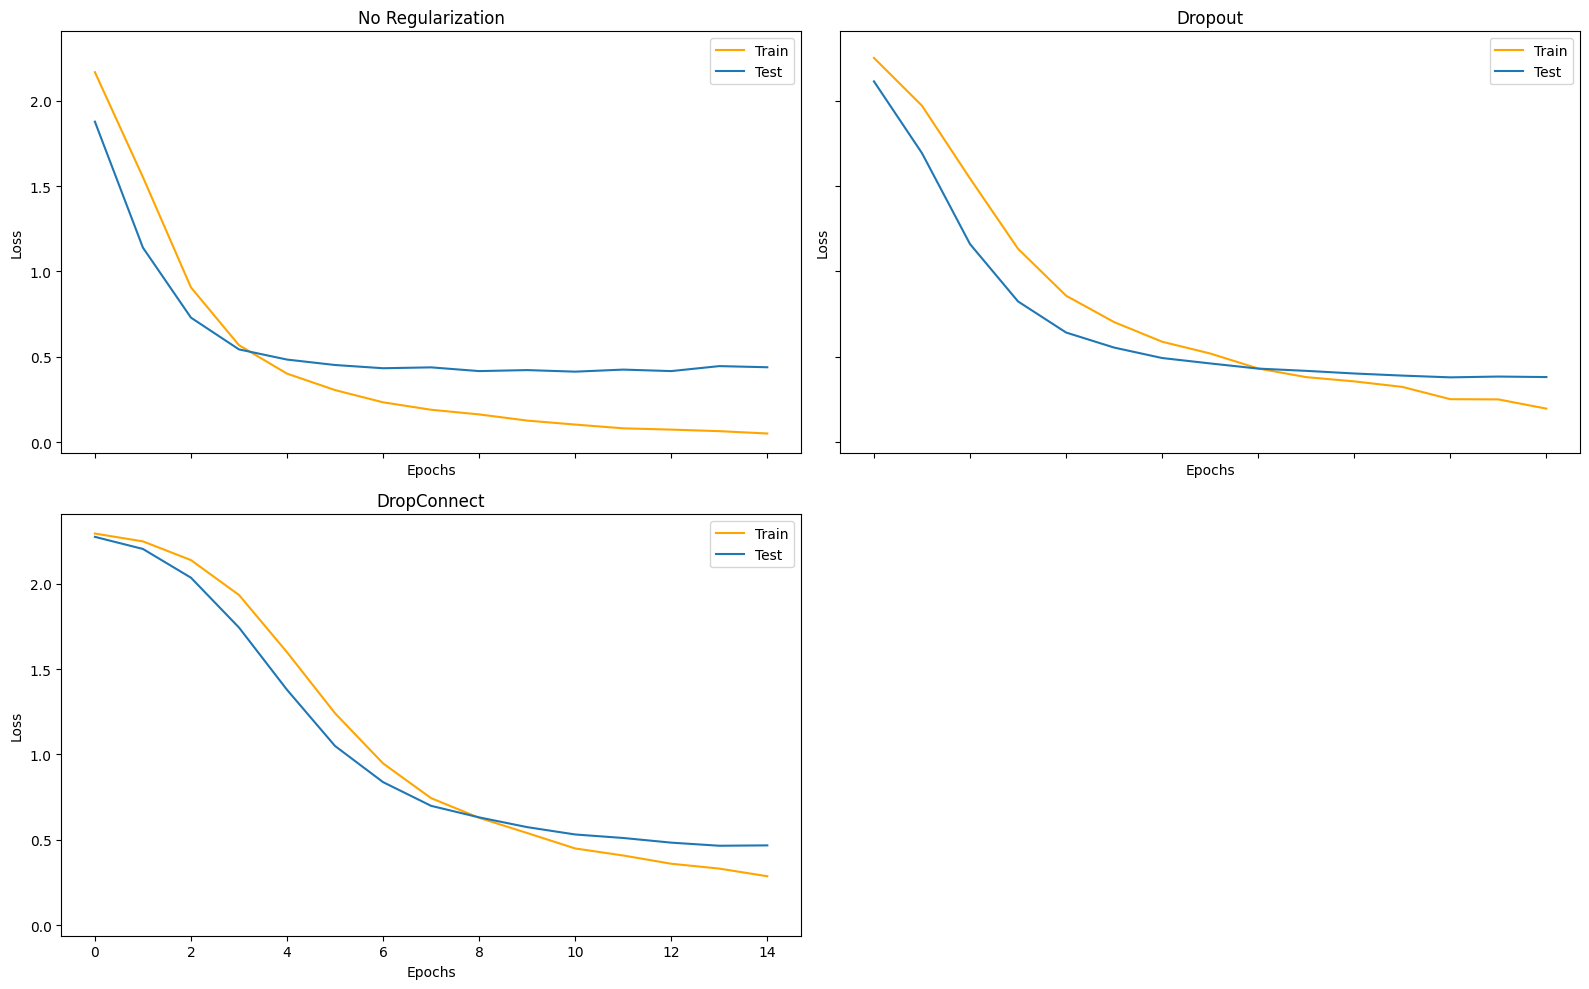

In [19]:
# グラフのプロット
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

config = {
    "No Regularization": {"loss": (train_losses, test_losses), "acc": (train_acces, test_acces)},
    "Dropout": {"loss": (train_dout_losses, test_dout_losses), "acc": (train_dout_acces, test_dout_acces)},
    "DropConnect": {"loss": (train_dcon_losses, test_dcon_losses), "acc": (train_dcon_acces, test_dcon_acces)},
}

for ax, (title, history) in zip(axes.flat, config.items()):
    train_loss, test_loss = history["loss"]

    ax.plot(range(epochs), train_loss, label="Train", linestyle="-", color="orange")
    ax.plot(range(epochs), test_loss, label="Test", linestyle="-")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()

# 不要なグラフを非表示にする
axes[1, 1].axis("off")

fig.tight_layout()
fig.show()

最後に、学習結果とテスト結果を用いて学習の評価を行います。

accuracyが95%前後になっていれば学習成功です。

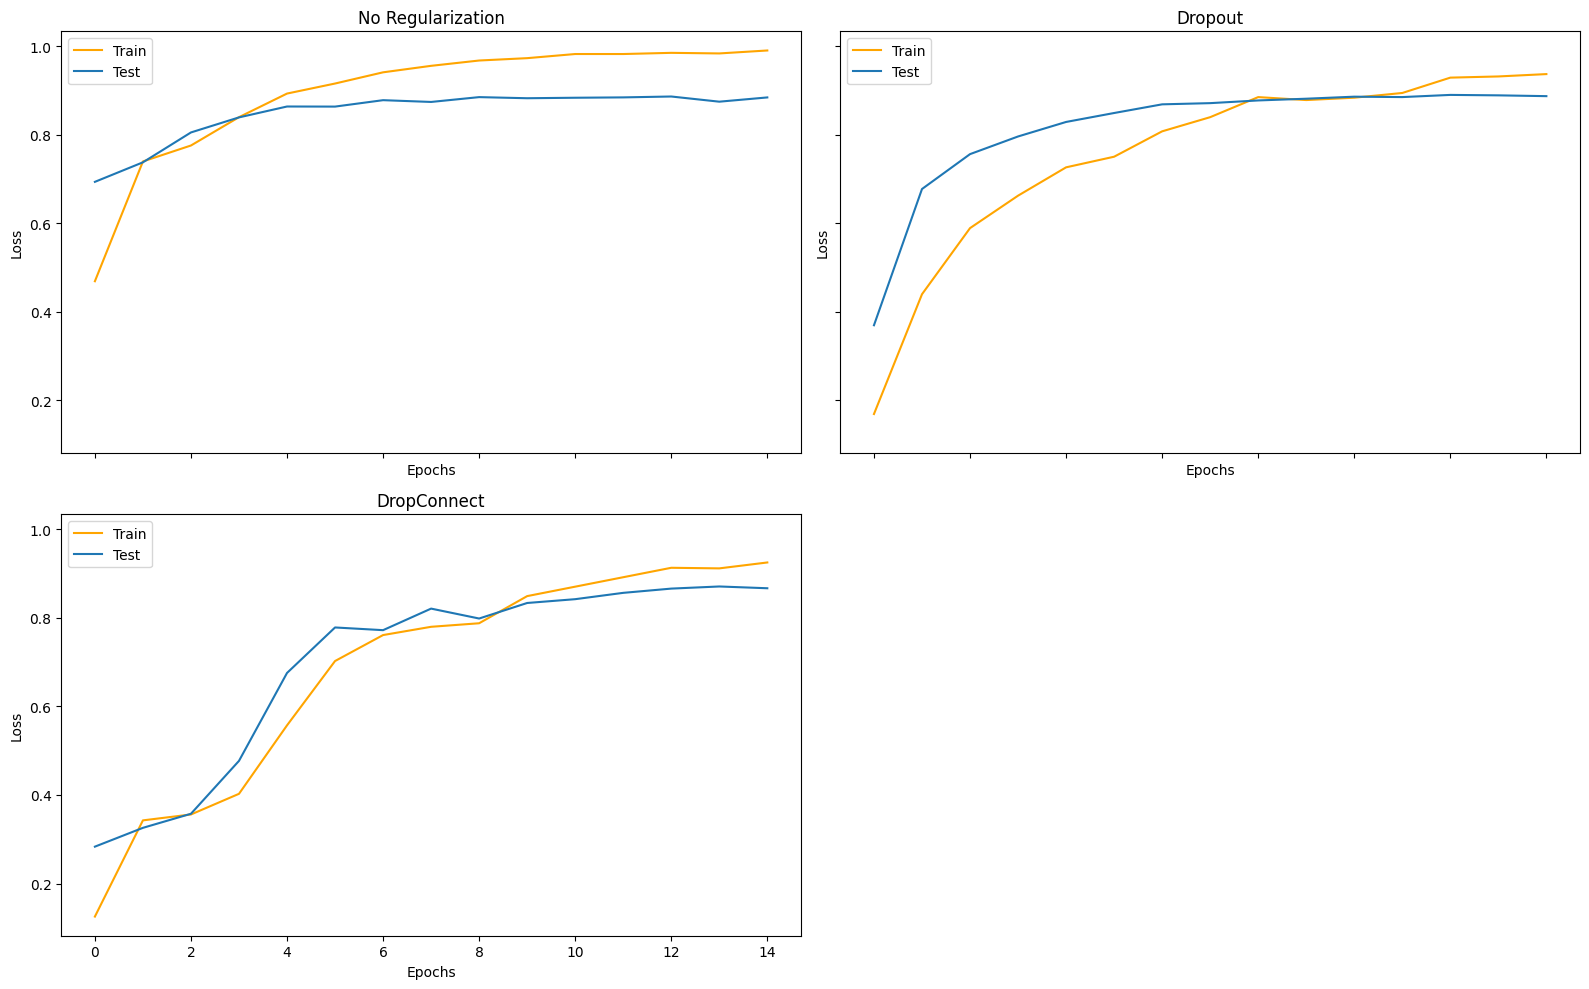

In [20]:
# グラフのプロット
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, (title, history) in zip(axes.flat, config.items()):
    train_acc, test_acc = history["acc"]

    ax.plot(range(epochs), train_acc, label="Train", linestyle="-", color="orange")
    ax.plot(range(epochs), test_acc, label="Test", linestyle="-")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()

# 不要なグラフを非表示にする
axes[1, 1].axis("off")

fig.tight_layout()
fig.show()

## データ拡張（PyTorch）

始めに`rabbit.jpg`の画像を読み込み、表示しましょう。

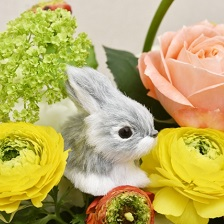

In [21]:
# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # マイドライブ内のデータを読み込むpathに設定
    img_path = "/content/drive/MyDrive/rabbit.jpg"
else:
    img_path = "rabbit.jpg"

img = Image.open(img_path)
display(img)


### Random Flip

Random Flipは画像を反転させるデータ拡張方法です。ここでは、`RandomHorizontalFlip`と`RandomVerticalFlip`を実装します。

`RandomHorizontalFlip`は水平方向に確率`p`に従って反転させます。

`RandomVerticalFlip`は垂直方向に確率`p`に従って反転させます。

`RandomHorizontalFlip`や`RandomVerticalFlip`は以下のような引数を持ちます。

```
【引数】
  p : 画像を反転させる確率 (ex. p=0.5)
```

分かりやすさのため、ここでは確率を1として必ず反転した画像を出力します。
* <font color="Red">問6-1. `transforms.RandomHorizontalFlip`を用いて、水平方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>


なお、エラーが出る場合は「rabbit.jpg」のファイルパスを確認してください。

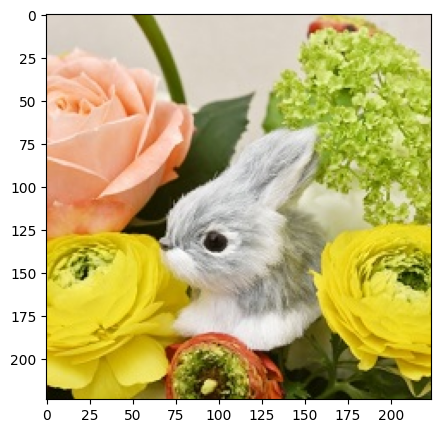

In [22]:
img = Image.open(img_path)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=1) ### 問6-1 ###
    ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


* <font color="Red">問6-2. `transforms.RandomVerticalFlip`を用いて、垂直方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>

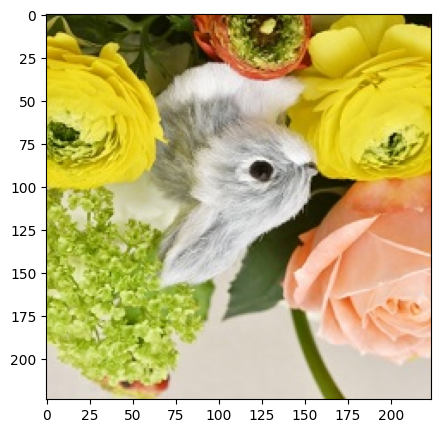

In [23]:
img = Image.open(img_path)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomVerticalFlip(p=1) ### 問6-2 ###
    ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Erase

Eraseの中でも、`RandomErasing`を実装します。`RandomErasing`は画像の中の長方形領域をランダムに選択しそのピクセルを消去させるデータ拡張方法です。

`RandomErasing`は以下のような引数を持ちます。

```
【引数】
  p : 画像の一部を消去させる確率 (ex. p=0.5)
  scale : 入力画像に対する消去領域の比率の範囲 (ex. scale=(0.05, 0.06))
  ratio : 消去領域のアスペクト比の範囲 (ex. ratio=(0.3, 3.0))
  value : 消去に関するパラメータで、RGBチャンネルをそれぞれ消去する際は、長さ3のタプルを指定 (ex. value=0)
```

分かりやすさのため、ここでは確率を1として必ずある一部分が消去された画像を出力します。

* <font color="Red">問7. `transforms.RandomErasing`を用いて、確率`p=1`で画像内の長方形領域をランダムにピクセル消去させるデータ拡張を加えてください。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">入力画像に対する消去領域の比率の範囲を(0.02, 0.33)とします。</font>
  * <font color="Red">消去領域のアスペクト比の範囲を(0.3, 3.3)とします。</font>
  * <font color="Red">消去領域の色は黒(=0)とします。</font>

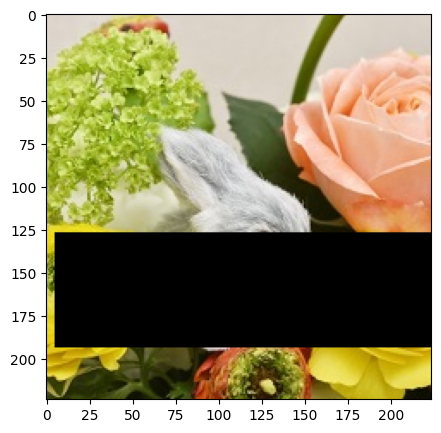

In [24]:
img = Image.open(img_path)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(0.02,0.33), ratio=(0.3,3.3), value=0) ### 問7 ###
    ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Crop

Cropsは画像の切り取りによって得られるデータ拡張方法です。Cropsの中でも、`CenterCrop`を実装します。`CenterCrop`は与えられた画像を中央で切り取ります。

`CenterCrop`は以下のような引数を持ちます。

```
【引数】
  size : 切り取るサイズ (ex. size=300, size=(200, 300))
```

* <font color="Red">問8. `transforms.CenterCrop`を用いて、画像の中央を(224, 224)のサイズで切り取るデータ拡張を加えてください。</font>

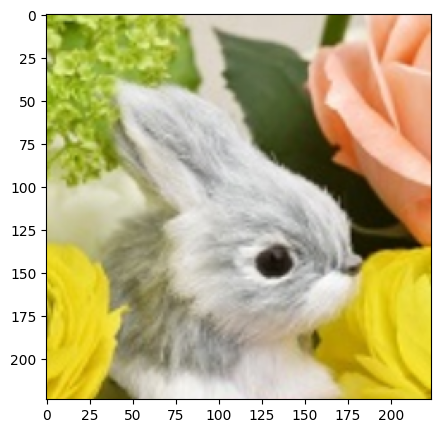

In [25]:
img = Image.open(img_path)
transform = transforms.Compose(
    [
        transforms.Resize(350),
        transforms.CenterCrop(size=(224,224)), ### 問8 ###
        transforms.ToTensor(),
    ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Brightness

Brightnessは画像の明るさを変更させることによって得られるデータ拡張方法です。Brightnessの中でも、`ColorJitter`を実装します。`ColorJitter`は画像の明るさ、コントラスト、彩度、色合いをランダムに変化させます。<br>

`ColorJitter`は以下のような引数を持ちます。

```
【引数】
  brightness : 明るさを調整するパラメータ (ex. brightness=0.80)
  contrast : コントラストを調整するパラメータ (ex. contrast=0.80)
  saturation : 彩度を調整するパラメータ (ex. saturation=0.80)
  hue : 色合いを調整するパラメータ (ex. hue=0.60)
```

* <font color="Red">問9. `transforms.ColorJitter`を用いて、画像の明るさを変更させるデータ拡張を加えましょう。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">明るさを0.75とします</font>
  * <font color="Red">コントラストを0.75とします</font>
  * <font color="Red">彩度を0.75とします</font>
  * <font color="Red">色合いを0.5とします</font>

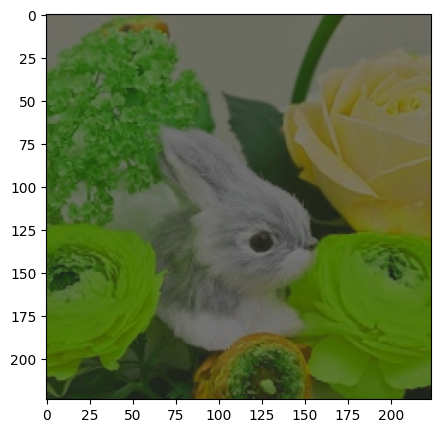

In [26]:
img = Image.open(img_path)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75, hue=0.5) ### 問9 ###
    ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Rotate

Rotateは画像を回転させることによって得られるデータ拡張方法です。Rotateの中でも、`RandomRotation`を実装します。`RandomRotation`はランダムに画像を回転させます。

`RandomRotation`は以下のような引数を持ちます。

```
【引数】
  degrees : 選択する角度の範囲を指定するパラメータ (ex. degrees=60)
  expand : 拡張を実行するか決定するパラメータ。
           trueの場合、出力を拡大して、回転した画像全体を格納できる大きさにし、
           falseまたは省略された場合は、出力画像を入力画像と同じ大きさにする。
  fill : 回転した画像の外側の領域を埋める値 (ex. fill=255)
```

* <font color="Red">問10. `transforms.RandomRotation`を用いて、画像を-90~90度回転させるデータ拡張を加えましょう。回転した画像の外側は黒色(=0)とし、出力画像は入力画像と同じ大きさにします。</font>

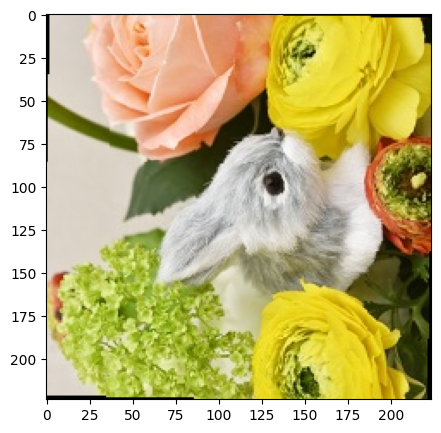

In [27]:
img = Image.open(img_path)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(-90,90), fill=0) ### 問10 ###
    ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Gaussian Filter

Gaussian Filterは画像にノイズを付与させることによって得られるデータ拡張方法です。Gaussian Filterの中でも、`GaussianBlur`を実装します。`GaussianBlur`は画像にランダムに選択されたノイズ（ぼかし）を付与します。

`GaussianBlur`は以下のような引数を持ちます。

```
【引数】
  kernel_size : カーネルのサイズを指定するパラメータ (ex. kernel_size=10)
  sigma : カーネルを作成するための標準偏差
           floatの場合、sigmaの値は固定されます
           float(min,max)の場合は、指定された範囲に収まるように均一にランダム選択されます
  
  
```

* <font color="Red">問11. `transforms.GaussianBlur`を用いて、画像にノイズを加えましょう。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">カーネルサイズを11とします</font>
  * <font color="Red">sigmaの値を(0.5,1.5)とします</font>

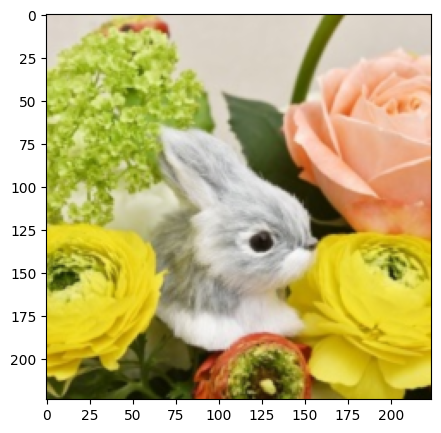

In [28]:
img = Image.open(img_path)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=11, sigma=(0.5,1.5)) ### 問11 ###
    ]
)

img = transform(img)
img = img.numpy().transpose((1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()


### RandAugment

RandAugmentはデータの拡張手法からランダムにサンプリングし、画像に適用するデータ拡張方法です。`RandAugment` は画像にランダムに選択されたデータ拡張手法を複数、繰り返し適用します。

`RandAugment` は以下のような引数を持ちます。

```
【引数】
  num_ops : 適用するデータ拡張変換の数
  magnitude : 各データ拡張手法の強さ
  num_magnitude_bins : カーネルのサイズを指定するパラメータ
  interpolation : イメージのサイズ変更に使用される補間モードを表します。
  fill : 変換した画像の外側の領域を埋める値 
```

* <font color="Red">問12. `transforms.RandAugment`を用いて、画像にランダムでサンプリングされた拡張手法を適用しましょう。また回転した画像の外側は黒色(=0)とし、出力画像は入力画像と同じ大きさにします。</font>
  * <font color="Red">num_opsを3とします</font>
  * <font color="Red">magnitudeの値を9とします</font>

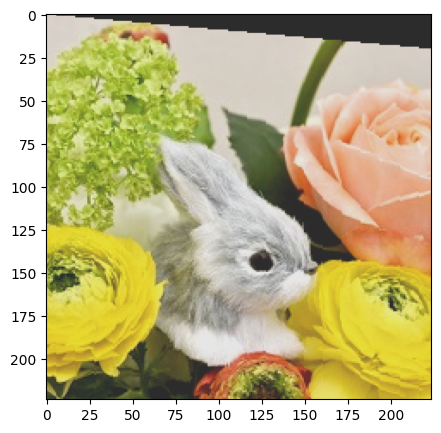

In [29]:
img = Image.open(img_path)

transform = transforms.Compose(
    [
        transforms.RandAugment(num_ops=3, magnitude=9, fill=0),  ### 問12 ###
        transforms.ToTensor(),
    ]
)

img = transform(img)
img = img.numpy().transpose((1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()


### MixUp

MixUpは2つの学習サンプルを混合して新たな学習サンプルを作成するデータ拡張手法です。

データとラベルのペア$(X_1, y_1)$と$(X_2, y_2)$から新たな学習サンプル$(X, y)$を作成します。ラベル$y_1, y_2$がone-hot表現の時、以下の式で$(X, y)$を作成します。

$$
X = \lambda X_1 + (1 - \lambda)X_2
$$
$$
y = \lambda y_1 + (1 - \lambda)y_2
$$

ここで、$\lambda$は0~1の範囲を取るパラメータで、ベータ分布$\beta(x,\alpha, \alpha)$からランダムにサンプリングします。$\alpha$はハイパーパラメータです。<br>
ベータ分布は以下のような確率密度関数として表すことができる。$C$は正規化定数。
$$
\beta(x,a,b) = C x ^ {a-1}(1-x) ^ {b-1}(0\leqq x\leqq 1)
$$


* <font color="Red">問13. MixUpにより新たな学習サンプルを作成しましょう。</font>
  * <font color="Red">問13-1. `np.random.beta()`関数を用いてベータ分布$\beta(\alpha, \alpha)$からサンプリングしましょう。</font>
  * <font color="Red">問13-2. パラメータ`lam`, 学習サンプル`x`, `x[index,:]`を使用して新たな学習データを算出する式を記述してください。</font>

In [30]:
torch.manual_seed(0)
np.random.seed(0)
transform=transforms.Compose([
    transforms.ToTensor(),
])
dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha) ### 問13-1 ###
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:] ### 問13-2 ###
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


target_a : 7
target_b : 6
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6294, 0.3706, 0.0000,
        0.0000])
lambda : 0.37061547061658573


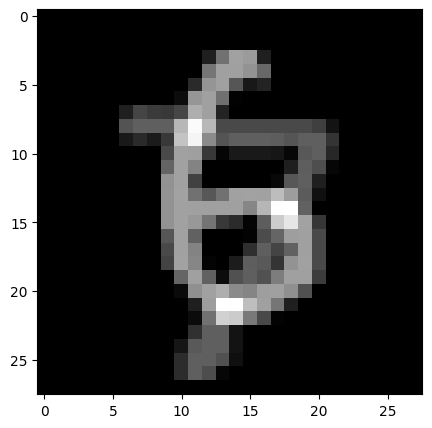

target_a : 3
target_b : 4
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.5503, 0.4497, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
lambda : 0.5503058575303685


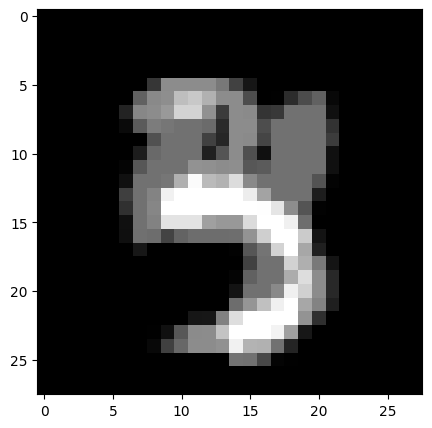

target_a : 7
target_b : 3
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.6992, 0.0000, 0.0000, 0.0000, 0.3008, 0.0000,
        0.0000])
lambda : 0.30081220227043654


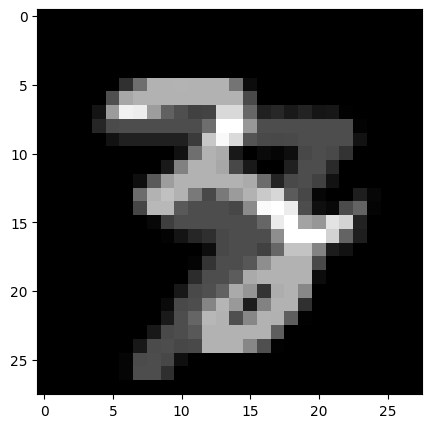

In [31]:
counter = 0
for data, label in dataloader:
    mixed_data, target_a, target_b, lam = mixup_data(
        data, label, alpha=0.5, use_cuda=torch.cuda.is_available()
    )
    counter += 1
    print(f"target_a : {target_a[0]}")
    print(f"target_b : {target_b[0]}")
    onehot_target_a = torch.eye(10)[target_a]
    onehot_target_b = torch.eye(10)[target_b]
    mixed_target_vector = onehot_target_a * lam + onehot_target_b * (1 - lam)
    print(f"mixed_target_vector: {mixed_target_vector[0]}")
    print(f"lambda : {lam}")
    img = mixed_data.numpy()[0].reshape((28, 28))
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap="gray")
    plt.show()
    if counter == 3:
        break


### データ拡張を行ったデータセットでモデルを学習する

MNISTデータセットを読み込む際にも、`transform` 引数に処理を渡すことでデータ拡張を行うことができます。
ここでは簡単のためRandAugmentを用いてデータ拡張を行います。

ただし本来、データ拡張はデータセットに適した手法を選択し、「現実に存在しそうなデータ」を生成することが重要であることに注意してください。

In [32]:
transform = transforms.Compose(
    [
        transforms.RandAugment(num_ops=3, magnitude=3),
        transforms.ToTensor(),
        lambda x: x.view(-1),
    ]
)
mnist_train = datasets.MNIST(
    root="./data", download=True, train=True, transform=transform
)

# RandAugmentを適用したDataLoaderを作成
train_dataloader = DataLoader(mnist_train, batch_size=100, sampler=train_sampler)

In [33]:
# モデルの宣言
model = MLP_classifier()
model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 学習エポック数
epochs = 15

# 損失のリストを設定
train_with_augmented_data_losses = []
test_with_augmented_data_losses = []
train_with_augmented_data_accs = []
test_with_augmented_data_accs = []

# epochsの回数繰り返す
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step(imgs, labels, model, optimizer)
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    train_loss /= len(train_dataloader)
    train_acc /= n_train_data
    train_with_augmented_data_losses.append(train_loss)
    train_with_augmented_data_accs.append(train_acc)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step(imgs, labels, model)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(preds, dim=1) == labels)
    test_loss /= len(test_dataloader)
    test_acc /= len(mnist_test)
    test_with_augmented_data_losses.append(test_loss)
    test_with_augmented_data_accs.append(test_acc)

    print(
        f"epoch: {epoch+1}, train loss: {train_loss:.5f}, train acc: {train_acc:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}"
    )


epoch: 1, train loss: 2.20097, train acc: 0.25867, test loss: 1.94093, test acc: 0.56820
epoch: 2, train loss: 1.74749, train acc: 0.60267, test loss: 1.25584, test acc: 0.78010
epoch: 3, train loss: 1.14395, train acc: 0.77467, test loss: 0.77337, test acc: 0.79220
epoch: 4, train loss: 0.80644, train acc: 0.78400, test loss: 0.59218, test acc: 0.83410
epoch: 5, train loss: 0.69850, train acc: 0.78800, test loss: 0.48630, test acc: 0.85080
epoch: 6, train loss: 0.59447, train acc: 0.84000, test loss: 0.47332, test acc: 0.86610
epoch: 7, train loss: 0.53363, train acc: 0.84533, test loss: 0.48208, test acc: 0.86050
epoch: 8, train loss: 0.53501, train acc: 0.84933, test loss: 0.44384, test acc: 0.86820
epoch: 9, train loss: 0.47611, train acc: 0.86533, test loss: 0.42137, test acc: 0.87750
epoch: 10, train loss: 0.42557, train acc: 0.88667, test loss: 0.40982, test acc: 0.87910
epoch: 11, train loss: 0.44632, train acc: 0.87467, test loss: 0.41325, test acc: 0.87360
epoch: 12, train lo

最後に学習結果を可視化してみましょう。\
DropoutやDropConnectと同様に、データ拡張も過学習を抑制する効果があることが確認できるはずです。

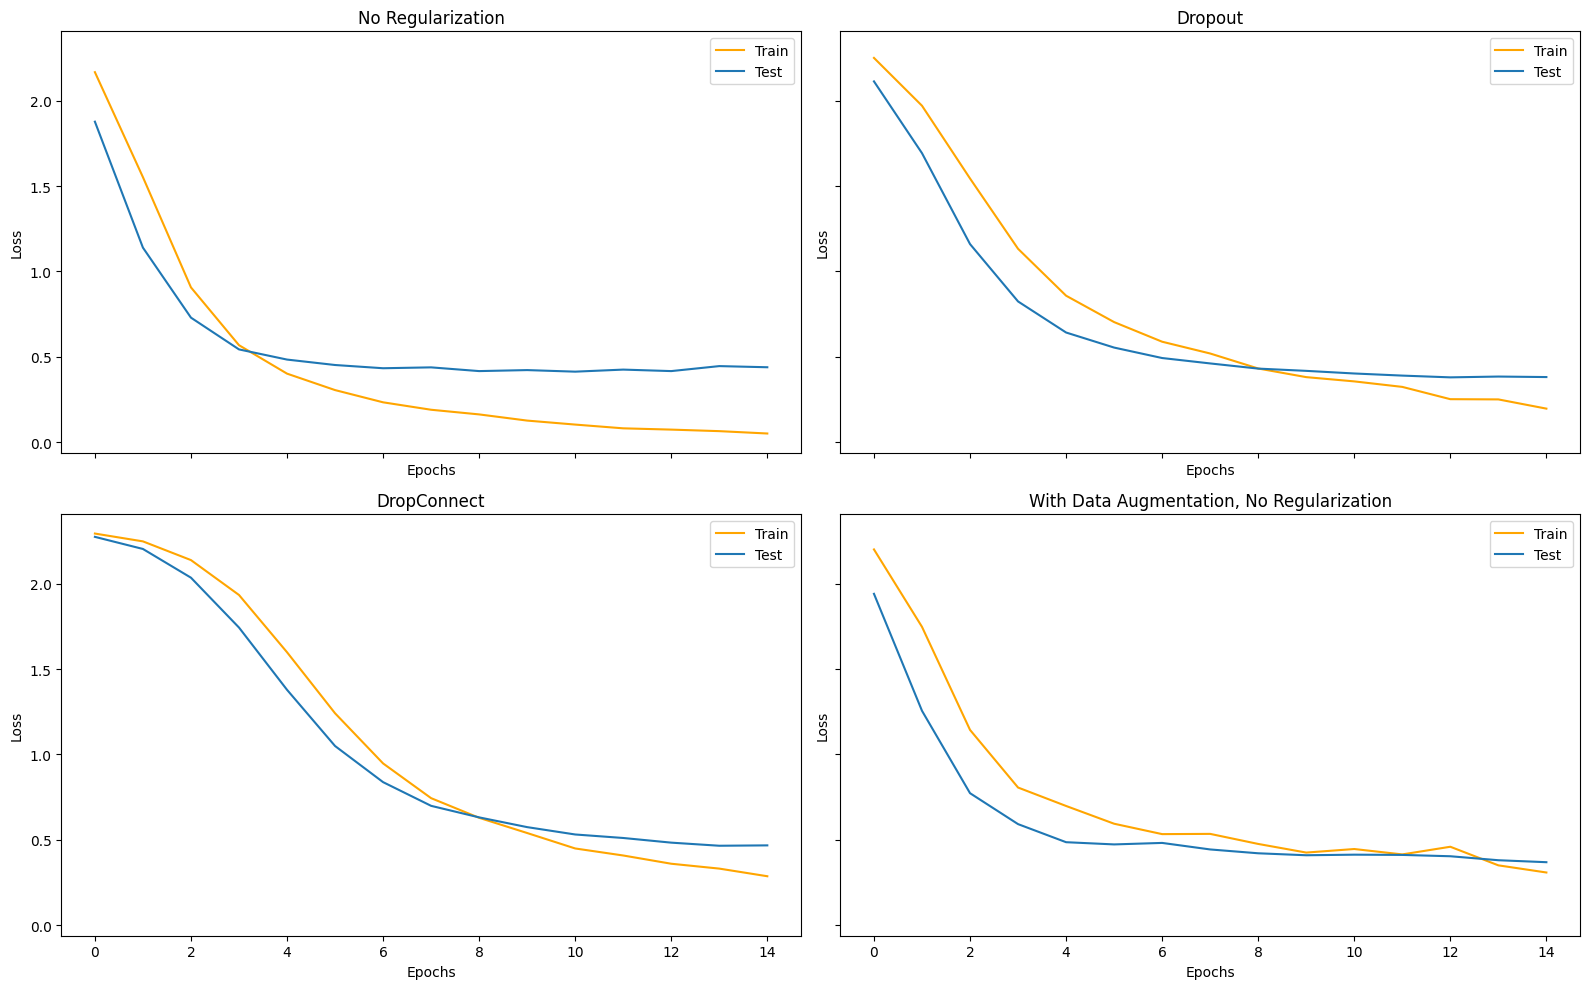

In [34]:
# グラフのプロット
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

config = {
    "No Regularization": {"loss": (train_losses, test_losses), "acc": (train_acces, test_acces)},
    "Dropout": {"loss": (train_dout_losses, test_dout_losses), "acc": (train_dout_acces, test_dout_acces)},
    "DropConnect": {"loss": (train_dcon_losses, test_dcon_losses), "acc": (train_dcon_acces, test_dcon_acces)},
    "With Data Augmentation, No Regularization": {"loss": (train_with_augmented_data_losses, test_with_augmented_data_losses), "acc": (train_with_augmented_data_accs, test_with_augmented_data_accs)},
}

for ax, (title, history) in zip(axes.flat, config.items()):
    train_loss, test_loss = history["loss"]

    ax.plot(range(epochs), train_loss, label="Train", linestyle="-", color="orange")
    ax.plot(range(epochs), test_loss, label="Test", linestyle="-")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
fig.show()

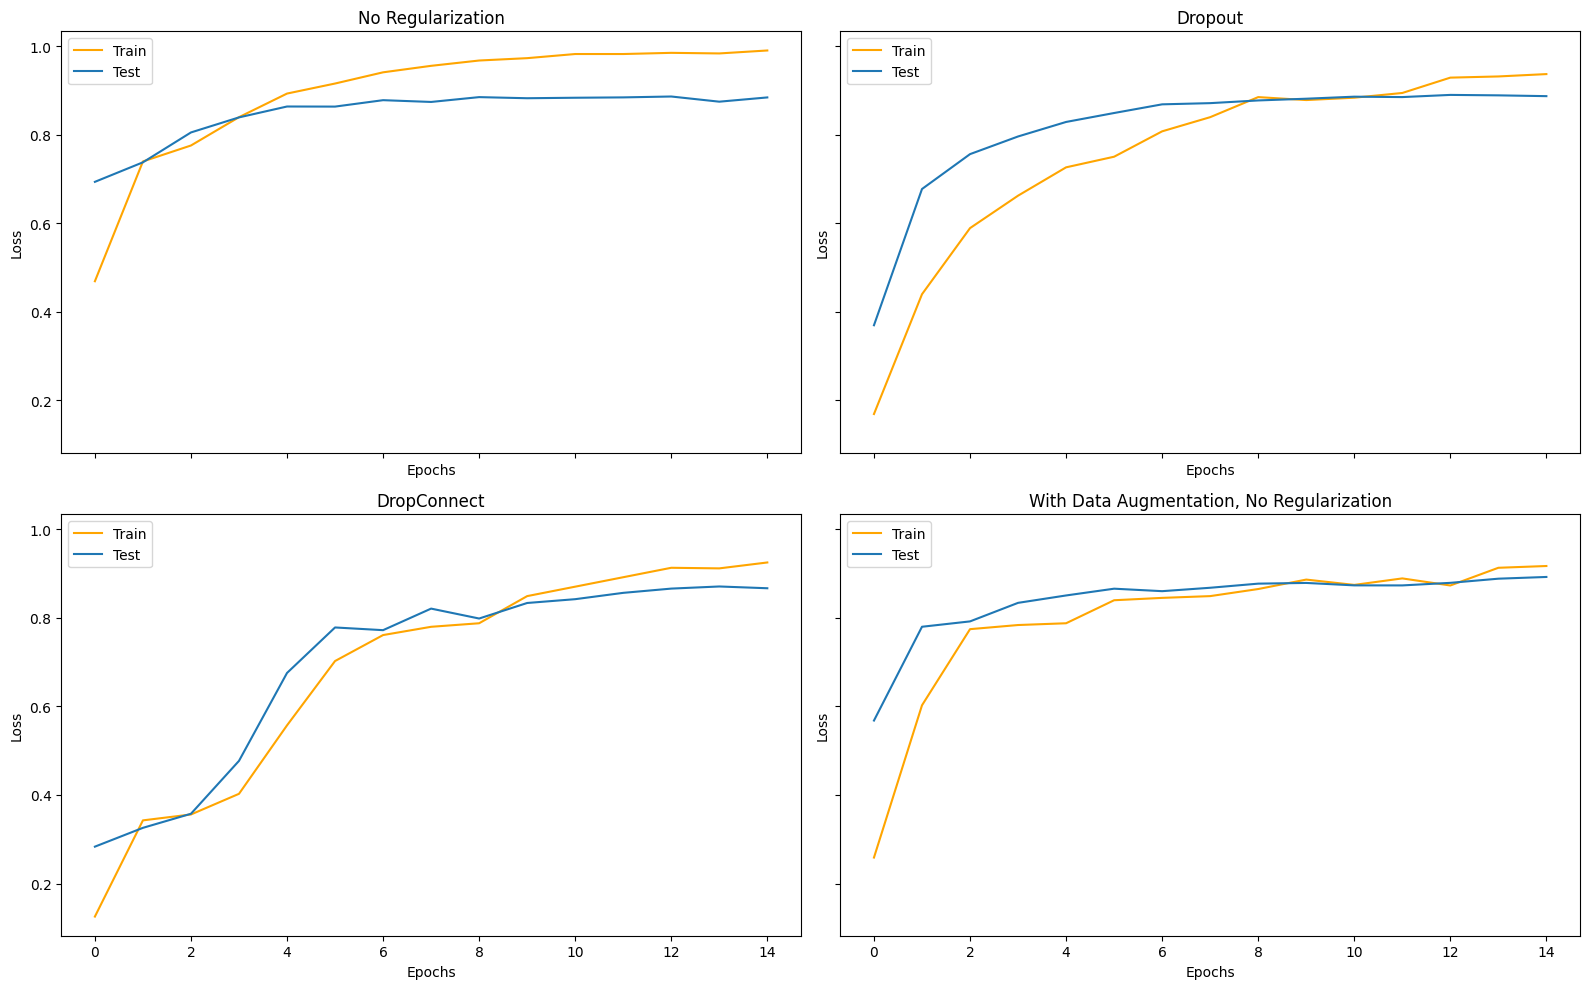

In [35]:
# グラフのプロット
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, (title, history) in zip(axes.flat, config.items()):
    train_acc, test_acc = history["acc"]

    ax.plot(range(epochs), train_acc, label="Train", linestyle="-", color="orange")
    ax.plot(range(epochs), test_acc, label="Test", linestyle="-")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
fig.show()